<a href="https://colab.research.google.com/github/amoazeni75/CMPT-983/blob/main/CMPT_983_Fall_2024_Generative_Models_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
import imageio
from tqdm import tqdm
from matplotlib import pyplot as plt
import random
import numpy as np
import seaborn as sns
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset

seed = 0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

## Preparing the Datasets

We have two datasets consisting of 2D data points.

You may download the dino dataset from https://drive.google.com/file/d/1y9PLHRzXvTMV6z8JWIeoULlaJR5qmKgu/view?usp=sharing.

To make it available to Colab, you will need to upload it by clicking on the following button:
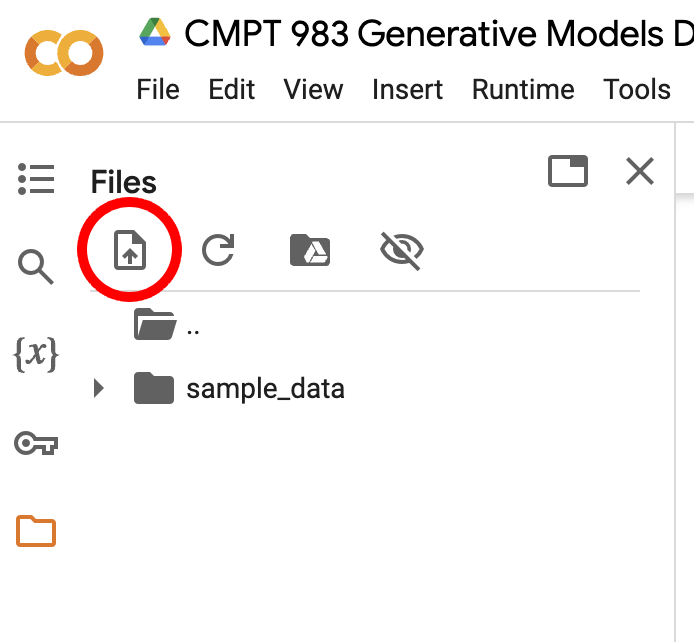

In [ ]:
def dino_dataset():
    df = pd.read_csv("DatasaurusDozen.tsv", sep="\t")
    df = df[df["dataset"] == "dino"]

    x = df["x"].tolist()
    x = np.array(x)
    y = df["y"].tolist()
    y = np.array(y)
    x = (x/54 - 1) * 4
    y = (y/48 - 1) * 4
    X = np.stack((x, y), axis=1)
    return X.astype(np.float32)

The handwritten digit dataset (called the MNIST dataset) does not need to be downloaded and is available by default.

In [ ]:
def mnist_dataset(id):
    df = pd.read_csv("sample_data/mnist_train_small.csv")

    cols = []
    for i, key in enumerate(df):
      if i >= 1:
        cols.append(np.array(df[key].tolist())[:,None])

    data = np.hstack(cols)

    ys, xs = np.nonzero(data[id,:].reshape((28,28)) > 0.5)
    xs = xs.astype(float) + np.random.rand(*xs.shape)
    ys = ys.astype(float) + np.random.rand(*ys.shape)

    coords_data = (np.hstack((xs[:,None], 27-ys[:,None])) - 14) / 2

    return coords_data.astype(np.float32)


## Plotting Function
We define a simple plotting function to visualize data points and generated samples.

In [ ]:
xmin, xmax = -6, 6
ymin, ymax = -6, 6
data_point_size = 50
nn_point_size = 50
generated_point_size = 50
legend_fontsize = 12
frameon = True
figsize = 8

def plot_data(sampler=None, data_points=None, zs=None, selected_z=None, title=None, f_name=None, arrow=False, eps=0.0):

    plt.figure(figsize=(figsize, figsize))
    if data_points is not None:
        plt.scatter(data_points[:, 0], data_points[:, 1], label="Real data points", color="blue", marker="s", s=data_point_size)
        if eps > 0.0:
            for center in data_points:
                circle = plt.Circle(center, eps, fill=True, alpha=0.2, linestyle="--", edgecolor="black", facecolor="gray")
                plt.gca().add_patch(circle)

    if sampler is not None:
        if zs is not None:
            generated = sampler(zs).detach()
            plt.scatter(generated[:, 0], generated[:, 1], label="Generated samples", color="orange", alpha=0.5, marker=".", s=generated_point_size)

        if selected_z is not None:
            selected = sampler(selected_z).detach()
            plt.scatter(selected[:, 0], selected[:, 1], label="Nearest neighbours", color="red",marker="*", s=nn_point_size)

            if data_points is not None and arrow:
                gen_to_data_vec = data_points - selected
                plt.quiver(selected[:, 0], selected[:, 1], 0.19*gen_to_data_vec[:, 0], 0.19*gen_to_data_vec[:, 1],
                          color="black", scale_units="xy", angles="xy", scale=0.2, width=0.0015, headwidth=10, headlength=10)

    plt.legend(fontsize = legend_fontsize, frameon=frameon, loc="upper right")

    plt.title(title, fontsize=15)
    plt.ylim(ymin, ymax)
    plt.xlim(xmin, xmax)
    plt.axis('off')

    if f_name:
        plt.savefig(f_name, bbox_inches="tight")
        plt.close()
    else:
        plt.show()

# Dataset
Run one of the cells below to load a dataset.

### Dino Dataset

In [ ]:
data = dino_dataset()

data = torch.from_numpy(data.astype(np.float32))
dataset = TensorDataset(data)

n = data.shape[0]

### Handwritten Digit Dataset

In [ ]:
data = mnist_dataset(9521)

data = torch.from_numpy(data.astype(np.float32))
dataset = TensorDataset(data)

n = data.shape[0]

### Visualization

We will visualize the data points below.

In [ ]:
plot_data(data_points=data, title=f"Dataset")

## Diffusion Model

Here we define the architecture of the score network.

In [ ]:
class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()

        self.ff = nn.Linear(size, size)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(x))

class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log(torch.Tensor([10000.0])) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size))
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

    def __len__(self):
        return self.size

class MLP(nn.Module):
    def __init__(self, hidden_size: int = 128, hidden_layers: int = 3, emb_size: int = 128):
        super().__init__()

        self.time_mlp = SinusoidalEmbedding(emb_size)
        self.input_mlp1 = SinusoidalEmbedding(emb_size, scale=25.0)
        self.input_mlp2 = SinusoidalEmbedding(emb_size, scale=25.0)

        concat_size = len(self.time_mlp) + \
            len(self.input_mlp1) + len(self.input_mlp2)
        layers = [nn.Linear(concat_size, hidden_size), nn.GELU()]
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))
        layers.append(nn.Linear(hidden_size, 2))
        self.joint_mlp = nn.Sequential(*layers)

    def forward(self, x, t):
        x1_emb = self.input_mlp1(x[:, 0])
        x2_emb = self.input_mlp2(x[:, 1])
        t_emb = self.time_mlp(t)
        x = torch.cat((x1_emb, x2_emb, t_emb), dim=-1)
        x = self.joint_mlp(x)
        return x

### Noise Schedule

Here we define the schedule of variances at different discretization steps.

In [ ]:
class NoiseScheduler():
    def __init__(self,
                 num_timesteps=1000,
                 beta_start=0.0001,
                 beta_end=0.02,
                 beta_schedule="linear"):

        self.num_timesteps = num_timesteps
        if beta_schedule == "linear":
            self.betas = torch.linspace(
                beta_start, beta_end, num_timesteps, dtype=torch.float32)
        elif beta_schedule == "quadratic":
            self.betas = torch.linspace(
                beta_start ** 0.5, beta_end ** 0.5, num_timesteps, dtype=torch.float32) ** 2

        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(
            self.alphas_cumprod[:-1], (1, 0), value=1.)

        # required for self.add_noise
        self.sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5

        # required for reconstruct_x0
        self.sqrt_inv_alphas_cumprod = torch.sqrt(1 / self.alphas_cumprod)
        self.sqrt_inv_alphas_cumprod_minus_one = torch.sqrt(
            1 / self.alphas_cumprod - 1)

        # required for q_posterior
        self.posterior_mean_coef1 = self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        self.posterior_mean_coef2 = (1. - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1. - self.alphas_cumprod)

    def reconstruct_x0(self, x_t, t, noise):
        s1 = self.sqrt_inv_alphas_cumprod[t]
        s2 = self.sqrt_inv_alphas_cumprod_minus_one[t]
        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)
        return s1 * x_t - s2 * noise

    def q_posterior(self, x_0, x_t, t):
        s1 = self.posterior_mean_coef1[t]
        s2 = self.posterior_mean_coef2[t]
        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)
        mu = s1 * x_0 + s2 * x_t
        return mu

    def get_variance(self, t):
        if t == 0:
            return 0

        variance = self.betas[t] * (1. - self.alphas_cumprod_prev[t]) / (1. - self.alphas_cumprod[t])
        variance = variance.clip(1e-20)
        return variance

    def step(self, model_output, timestep, sample):
        t = timestep
        pred_original_sample = self.reconstruct_x0(sample, t, model_output)
        pred_prev_sample = self.q_posterior(pred_original_sample, sample, t)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output)
            variance = (self.get_variance(t) ** 0.5) * noise

        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample

    def add_noise(self, x_start, x_noise, timesteps):
        s1 = self.sqrt_alphas_cumprod[timesteps]
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps]

        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)

        return s1 * x_start + s2 * x_noise

    def __len__(self):
        return self.num_timesteps

### Sampling Procedure

Here we define the sampling procedure used to sample from a DDPM model.

In [ ]:
def ddpm_sampler(model, noise_scheduler):
    def sample_fn(sample):
        model.eval()
        timesteps = list(range(len(noise_scheduler)))[::-1]
        for i, t in enumerate(timesteps):
            t = torch.from_numpy(np.repeat(t, sample.shape[0])).long()
            with torch.no_grad():
                residual = model(sample, t)
            sample = noise_scheduler.step(residual, t[0], sample)
        return sample
    return sample_fn

### Hyperparameters

Here we define the hyperparameters.

In [ ]:
train_batch_size = 32
num_epochs = 2000
learning_rate = 1e-3
num_timesteps = 50
beta_schedule = "linear"
embedding_size = 128
hidden_size = 128
hidden_layers = 3

### Training Loop
Below is the training loop. Run the code snippet below to train the model.

In [ ]:
eval_batch_size = 1000
save_images_step = 250

plots_dir = f"ddpm/plots"
os.makedirs(plots_dir, exist_ok=True)

dataloader = DataLoader(dataset, batch_size=train_batch_size, shuffle=True, drop_last=True)

ddpm_model = MLP(hidden_size=hidden_size, hidden_layers=hidden_layers, emb_size=embedding_size)

noise_scheduler = NoiseScheduler(num_timesteps=num_timesteps, beta_schedule=beta_schedule)

optimizer = torch.optim.AdamW(ddpm_model.parameters(), lr=learning_rate)

global_step = 0
print("Training DDPM model...")
progress_bar = tqdm(total=num_epochs*len(dataloader))
for epoch in range(num_epochs):
    for step, batch in enumerate(dataloader):
        ddpm_model.train()
        optimizer.zero_grad()
        batch = batch[0]
        noise = torch.randn(batch.shape)
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        noise_pred = ddpm_model(noisy, timesteps)
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()

        nn.utils.clip_grad_norm_(ddpm_model.parameters(), 1.0)
        optimizer.step()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "step": global_step}
        progress_bar.set_postfix(**logs)
        global_step += 1

    if epoch % save_images_step == 0 or epoch == num_epochs - 1:
        # generate data with the model to later visualize the learning process
        sample = torch.randn(eval_batch_size, data.shape[1])
        plot_data(sampler=ddpm_sampler(ddpm_model, noise_scheduler), data_points=data, zs=sample, title=f"DDPM Training", f_name=f"{plots_dir}/ddpm-epoch-{epoch:04}.png")

progress_bar.close()

sample = torch.randn(eval_batch_size, data.shape[1])
plot_data(sampler=ddpm_sampler(ddpm_model, noise_scheduler), zs=sample, title=f"DDPM Final Samples", f_name=f"{plots_dir}/ddpm-final.png")
plot_data(sampler=ddpm_sampler(ddpm_model, noise_scheduler), zs=sample, title=f"DDPM Final Samples")

## Implcit Model
Here we define a simple neural sampler implicit model consisting of a few fully connected layers. We initialize its weights using a truncated standard Gaussian.

In [ ]:
def init_weights(m):
    def truncated_normal_init(t, mean=0.0, std=0.5):
        torch.nn.init.normal_(t, mean=mean, std=std)
        while True:
            cond = torch.logical_or(t < mean - 2 * std, t > mean + 2 * std)
            if not torch.sum(cond):
                break
            t = torch.where(cond, torch.nn.init.normal_(torch.ones(t.shape), mean=mean, std=std), t)
        return t

class Generator(nn.Module):
    def __init__(self, n_mlp=5, in_dim=32, out_dim=2, hidden_dim=128):
        super().__init__()
        assert(n_mlp >= 2)

        layers = [nn.Linear(in_dim, hidden_dim), nn.LeakyReLU(0.2)]
        for i in range(n_mlp - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Sigmoid())
        layers.append(nn.Linear(hidden_dim, out_dim))
        self.layers = nn.Sequential(*layers)

    def forward(self, latents):
        return self.layers(latents)

Here we define the sampling procedure used to sample from an IMLE model.

In [ ]:
def imle_sampler(model):
    def sample_fn(z):
        model.eval()
        sample = model(z)
        return sample
    return sample_fn

### Hyperparameters
Here we define the hyperparameters.

In [ ]:
lr = 0.01               # learning rate
noise_coef = 0.000001   # additive noise coeficient for perturbing the samples
epochs = 30000          # number of passes over the data
staleness = 20          # number of passes over the data before new samples are drawn
sample_factor = 10      # number of samples to draw

eval_batch_size = 1000
save_images_step = 5000

### Nearest Neighbours
Here we define a naive function to find nearest neighbour of each data point. The process for finding nearest neighbous can be accelerated using a k-NN search algorithm, such as [DCI](https://arxiv.org/abs/1703.00440).

In [ ]:
def find_nn(data_point, generated):
    dists = torch.sum((generated - data_point)**2, dim=1)
    dists = dists**0.5
    return torch.argmin(dists).item()

### Vanilla IMLE
Here we implement a basic version of Vanilla IMLE.

In [ ]:
zdim = 2  # latent space dimension
imle_model = Generator(n_mlp=4, in_dim=zdim, hidden_dim=32)

optimizer = torch.optim.Adam(imle_model.parameters(), lr=lr)
imle_nn_z = torch.randn(n, zdim)
nz = data.shape[0]*sample_factor

plots_dir = f"imle/plots"
os.makedirs(plots_dir, exist_ok=True)

print("Training vanilla IMLE model...")
progress_bar = tqdm(total=epochs)

for e in range(epochs):
    with torch.no_grad():
        if e % staleness == 0:
            imle_model.eval()
            zs = torch.randn(nz, zdim)
            generated = imle_model(zs).detach()

            ## If the dataset or sample_factor is large, find_nn is extremely slow.
            ## It's better to use a k-NN search library here,
            ## e.g., https://github.com/niopeng/dciknn_cuda
            ## If the dataset is large, you should use mini-batches to
            ## avoid going over the entire dataset at once.
            nns = torch.tensor([find_nn(d, generated) for d in data], dtype=torch.long)
            imle_nn_z = zs[nns] + torch.randn(nns.shape[0], zdim) * noise_coef
        if e % save_images_step == 0:
            plot_data(sampler=imle_sampler(imle_model), data_points=data, zs=zs, selected_z=imle_nn_z, title=f"Vanilla IMLE Training", f_name=f"{plots_dir}/imle-epoch-{e:05}.png", arrow=True)

    imle_model.train()
    optimizer.zero_grad()
    outs = imle_model(imle_nn_z)
    dists = torch.sum((outs - data)**2, dim=1)

    loss = dists.mean()
    loss.backward()
    optimizer.step()

    progress_bar.update(1)
    logs = {"loss": loss.detach().item(), "step": e}
    progress_bar.set_postfix(**logs)

progress_bar.close()

zs = torch.randn(eval_batch_size, zdim)
plot_data(sampler=imle_sampler(imle_model), zs=zs, title="Vanilla IMLE Final Samples", f_name=f"{plots_dir}/imle-final.png")
plot_data(sampler=imle_sampler(imle_model), zs=zs, title="Vanilla IMLE Final Samples")

### RS-IMLE
Here we implement Rejection Sampling IMLE. We reject samples that are too close to a data point.

In [ ]:
def find_nn_rsimle(data_point, generated, limit = 1e-3):
    l2_distances = np.linalg.norm(generated[:, np.newaxis] - data_point , axis=2)
    to_exclude = l2_distances < limit
    bad_samples_list = np.expand_dims(to_exclude.any(axis=1),-1)
    bad_samples_list_repeated = np.tile(bad_samples_list,to_exclude.shape[1])
    l2_distances[bad_samples_list_repeated] = np.inf
    result = np.argmin(l2_distances,axis=0)
    return result

Here we define the distance threshold to use to reject samples. Samples whose distance to a data point are smaller than the threshold will be rejected. It trades off precision of the samples and overfitting. Higher thresholds will make the samples more precise, and lower thresholds prevent the model from being overfitted.

In [ ]:
distance_threshold = 6e-2   # Epsilon to reject samples

Below is the training loop. Run the code snippet below to train the model.

In [ ]:
zdim = 2  # latent space dimension
rsimle_model = Generator(n_mlp=4, in_dim=zdim, hidden_dim=32)

optimizer = torch.optim.Adam(rsimle_model.parameters(), lr=lr)
imle_nn_z = torch.randn(n, zdim)
nz = data.shape[0]*sample_factor

plots_dir = f"rsimle/plots"
os.makedirs(plots_dir, exist_ok=True)

print("Training RS-IMLE model...")
progress_bar = tqdm(total=epochs)

for e in range(epochs):
    with torch.no_grad():
        if e % staleness == 0:
            rsimle_model.eval()
            zs = torch.randn(nz, zdim)
            generated = rsimle_model(zs).detach()

            ## If the dataset or sample_factor is large, find_nn is extremely slow.
            ## It's better to use a k-NN search library here,
            ## e.g., https://github.com/niopeng/dciknn_cuda
            ## If the dataset is large, you should use mini-batches to
            ## avoid going over the entire dataset at once.
            nns = torch.tensor(find_nn_rsimle(data, generated, limit=distance_threshold), dtype=torch.long)
            imle_nn_z = zs[nns] + torch.randn(nns.shape[0], zdim) * noise_coef

        if e % save_images_step == 0:
            plot_data(sampler=imle_sampler(rsimle_model), data_points=data, zs=zs, selected_z=imle_nn_z, title=f"RS-IMLE Training", f_name=f"{plots_dir}/rsimle-epoch-{e:05}.png", arrow=True, eps=distance_threshold)

    rsimle_model.train()
    optimizer.zero_grad()
    outs = rsimle_model(imle_nn_z)
    dists = torch.sum((outs - data)**2, dim=1)
    loss = dists.mean()
    loss.backward()
    optimizer.step()

    progress_bar.update(1)
    logs = {"loss": loss.detach().item(), "step": e}
    progress_bar.set_postfix(**logs)

progress_bar.close()

zs = torch.randn(eval_batch_size, zdim)
plot_data(sampler=imle_sampler(rsimle_model), zs=zs, title="RS-IMLE Final Samples", f_name=f"{plots_dir}/rsimle-final.png")
plot_data(sampler=imle_sampler(rsimle_model), zs=zs, title="RS-IMLE Final Samples")